# Fetching crypto and tweets data.

In [23]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.preprocessing import OrdinalEncoder
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import re


class CryptoApi:
    def __init__(self) -> None:
        self.mother_endpoint = "https://min-api.cryptocompare.com/data"

        with open('token.txt', 'r') as f:
            self.TOKEN = f.readline()

        self.HEADER = {'Authorization': self.TOKEN,
                       "Content-Type": 'application/json'}


    def get_data(self, crypto:str, currency:str, period:str, period_count:int, allData=0):
        '''Returns crypto summary for a given period in specified currency.

        Args:
            crypto: str
                BTC/ETH/DOGE etc.
            currency: str
                USD/EUR/UAH etc.
            period: str 
                day/hour/minute.
            period_count: int
                last n of a period (n days)
                n = 1 returns revious day/hour/minute + current
            allData: int
                bool doen't work
                1 - get all records;
                0 - get specified amount of period_count.
        Returns:
            dict: json containing request's response.
        '''        

        endpoint = f'{self.mother_endpoint}/v2/histo{period}?fsym={crypto}&tsym={currency}&limit={period_count}'
        response = requests.get(endpoint, params={'allData':allData}, headers=self.HEADER)
        
        return response.json()
    
    def execute_custom_getrequest(self, endpoint:str):
        return requests.get(endpoint, headers=self.HEADER)
    
data = CryptoApi()
#data.get_data('btc','usd','day',29)

#TODO: Consider Api v2

In [24]:
class TweetScraper:    
    def __init__(self, start='2023-04-11', end='2023-04-13', freq='d'):         
        self.date_range = pd.date_range(start=start, end=end, freq=freq)

        self.queries = [f"from:elonmusk since:{d1.strftime('%Y-%m-%d')} until:{d2.strftime('%Y-%m-%d')}"
                        for d1, d2 in zip(self.date_range, self.date_range[1:])]

    def sequent_download_tweets(self, query):
        tweets = []
        for tweet in sntwitter.TwitterSearchScraper(query).get_items():
            tweets.append(tweet)
        return tweets

    def parallel_download_tweets(self):
        tweets_list = []
        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = [executor.submit(self.sequent_download_tweets, query) for query in self.queries]
                
            # Append results to the tweets list
            for future in as_completed(futures):
                tweets_list += future.result()
                
        return tweets_list


#tweets_df = pd.DataFrame(parallel_download_tweets())
#tweets_df.to_csv('elon_twt.csv')

#latest_tweets  = pd.DataFrame(tweets_scraper.parallel_download_tweets())
#latest_tweets.to_csv('elon_twt.csv')

#tweets_scraper = TweetScraper(start='2023-04-13', end='2023-05-05')
#tweets_scraper.sequent_download_tweets(tweets_scraper.queries[0])

In [25]:
raw_data = data.get_data('btc','usd','day',30)

df = pd.DataFrame(raw_data['Data']['Data'])
df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x).date())

raw_btc = data.get_data('btc','usd','day', 2000) #10 years bitcoin


btc_df = pd.DataFrame(raw_btc['Data']['Data'])
btc_df['time'] = btc_df['time'].apply(lambda x: datetime.fromtimestamp(x).date())

# Analysis of tweets

In [26]:
'''
TODO: GENERAL DATA TASKS:
0) find a way to deal with multiple tweets for a day
1) merge 2 datasets into 
2) imput missing data, maybe try interpolation or expectation maximization
    2.1) compare with mean, median imput methods
3) ivestigate relationship within data, maybe correlation matrix etc
'''

tweets_df = pd.read_csv('elon_tweets.csv', index_col=0)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
                                                
tweets_df = (tweets_df
             .dropna(axis=1, how='all')
             .drop(['vibe','cashtags'], axis=1)) # 1 and 18 notna values respectively  

## Diving into sparse columns

In [27]:
#tweets_df = tweets_df[tweets_df.columns[tweets_df.notna().sum()==0]]

sparse_cols = tweets_df.columns[tweets_df.notnull().mean() < 1.0].values.copy()

tweets_df[sparse_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21775 entries, 0 to 21774
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   links             1425 non-null   object 
 1   media             1370 non-null   object 
 2   quotedTweet       609 non-null    object 
 3   inReplyToTweetId  16915 non-null  float64
 4   inReplyToUser     16915 non-null  object 
 5   mentionedUsers    16386 non-null  object 
 6   hashtags          50 non-null     object 
 7   card              853 non-null    object 
 8   viewCount         2934 non-null   float64
dtypes: float64(2), object(7)
memory usage: 1.7+ MB


In [28]:
#mod_tweets_df = tweets_df[notna_cols].copy()
mod_tweets_df = tweets_df.copy()

mod_tweets_df = (mod_tweets_df[mod_tweets_df['lang']=='en']
                 .drop(['id','url','source','sourceUrl'], axis=1)                 
                 .reset_index(drop=True)
                 .copy())


#mod_tweets_df = mod_tweets_df.drop(['lang','inReplyToTweetId','conversationId'], axis=1)
mod_tweets_df = mod_tweets_df.drop(['lang'], axis=1)

In [29]:
'''print(len(mod_tweets_df))
print(len(mod_tweets_df['conversationId'].unique()))
print(len(mod_tweets_df['inReplyToTweetId'].unique()))
print(mod_tweets_df['isReplied'].sum())
print(mod_tweets_df['isReplied'].where(mod_tweets_df['isReplied'] == 0).dropna().shape[0])'''

"print(len(mod_tweets_df))\nprint(len(mod_tweets_df['conversationId'].unique()))\nprint(len(mod_tweets_df['inReplyToTweetId'].unique()))\nprint(mod_tweets_df['isReplied'].sum())\nprint(mod_tweets_df['isReplied'].where(mod_tweets_df['isReplied'] == 0).dropna().shape[0])"

## Data cleaning and preprocessing

In [30]:
encoder = OrdinalEncoder()
mod_tweets_df['sourceLabel_encoded'] = encoder.fit_transform(mod_tweets_df['sourceLabel'].values.reshape(-1, 1))
mod_tweets_df['isReplied']   = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['inReplyToUser']]
mod_tweets_df['isMentioned'] = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['mentionedUsers']]

#mod_tweets_df = mod_tweets_df.drop(['sourceLabel','inReplyToUser','mentionedUsers'], axis=1)


def extract_dict(line: str, prepare_to_df: False):
    """Extracts data from a dict represented as string and makes it a dict.

    Args:
        line (str): row of a Series/DataFrame to be preprocessed.
        prepare_to_df (bool): prepares extracted dict to be wrapped into DataFrame.

    Returns:
        dict: extracted dict from string.
    """    

    extracted_content = dict(re.findall(r"'(\w+)': '?({.*}|datetime.datetime\(.*\)|[\w\d/:\. ]*)'?", line))
    
    # Wraps dict values into lists to be easily represented as a DataFrame row.
    if prepare_to_df:
        for key,value in extracted_content.items():
            if value == '':
                extracted_content[key] = [None]
            else:
                extracted_content[key] = value
        
    return extracted_content


new_df = mod_tweets_df.copy()     
extracted_df = (pd.DataFrame([*mod_tweets_df['user']
                              .apply(lambda x: extract_dict(x, True))])
                )

new_df = (pd.concat([new_df, extracted_df], axis=1)
            .drop(['user','username','id','displayname','verified','created',
                    'location','protected','profileImageUrl','profileBannerUrl',
                    'rawDescription','renderedDescription','favouritesCount',
                    'friendsCount','mediaCount','statusesCount'], axis=1))
'''.drop(['user','username','id','displayname','verified','created',
                 'location','protected','link','profileImageUrl','profileBannerUrl',
                 'label', 'rawDescription','renderedDescription','mediaCount','favouritesCount',
                 'descriptionLinks','statusesCount','friendsCount'], axis=1))'''

".drop(['user','username','id','displayname','verified','created',\n                 'location','protected','link','profileImageUrl','profileBannerUrl',\n                 'label', 'rawDescription','renderedDescription','mediaCount','favouritesCount',\n                 'descriptionLinks','statusesCount','friendsCount'], axis=1))"

In [31]:
# Converting columns containing numbers to int after extraction.
for column in new_df:
    if 'Count' in column:
        new_df[column] = new_df[column].astype('Int64').copy()

<AxesSubplot:>

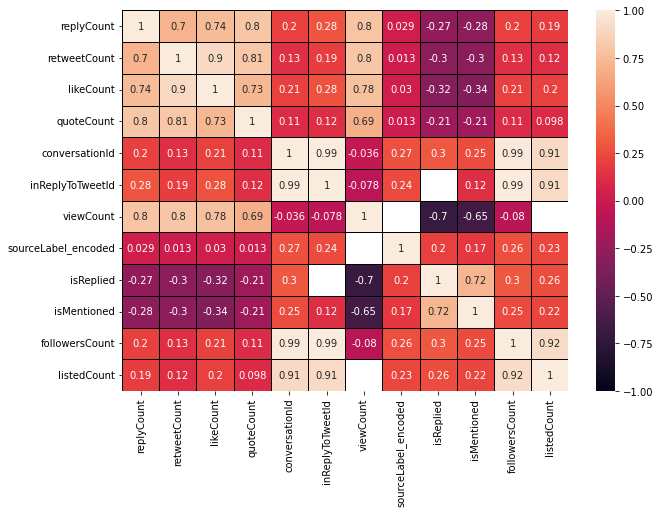

In [32]:
'''
TODO:
1) Check whenether @tags are ok for text analysis, 
   how to treat them.
2) Make a column with number of tags.
'''

plt.figure(figsize=(10,7))
sns.heatmap(new_df.corr(),vmin=-1, vmax=1, annot=True, linecolor='black',linewidths=1)

In [33]:
new_df[['rawContent','isReplied','isMentioned']].query("rawContent.str.contains('@')")

new_df['mentionsCount'] = new_df['rawContent'].str.count(r'@[\w\d]+')
new_df[['rawContent','mentionsCount']]

,rawContent,mentionsCount
0,"Please ignore prior tweets, as that was someon...",0
1,I made the volume on the Model S http://t.co/w...,0
2,Went to Iceland on Sat to ride bumper cars on ...,0
3,That was a total non sequitur btw,0
4,"Great Voltaire quote, arguably better than Twa...",0
...,...,...
18311,@DimaZeniuk @SpaceX @SirineAti @captainarve @a...,11
18312,@DimaZeniuk @SpaceX @SirineAti @captainarve @a...,11
18313,@teslaownersSV Got to break a few eggs to make...,1
18314,@Jason @DeanPreston @GrowSF Good question,3


In [34]:
new_df['mentions'] = new_df['rawContent'].apply(lambda x : re.findall(r'(@[^\s]+)', x))

count = 0
for a,b in new_df[['mentionsCount','mentions']].values:
    if a==len(b):
        count +=1 
print(count==len(new_df))

True


In [35]:
tweets_df.columns[tweets_df.columns.isin(new_df.columns)==False]

Index(['url', 'id', 'user', 'lang', 'source', 'sourceUrl'], dtype='object')

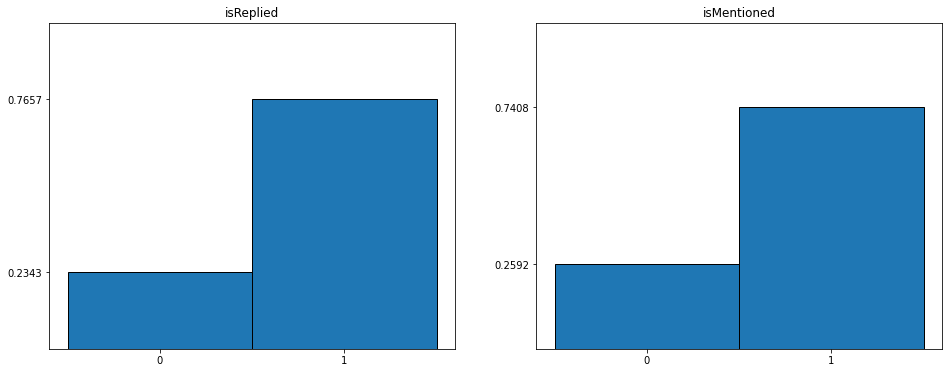

In [36]:
def plot_binary(col_names, plot_size=(16,6)):
    fig, ax = plt.subplots(ncols=len(col_names))
    fig.set_size_inches(plot_size)   
    
    for i in range(len(col_names)):
        freqs, bins, _ = ax[i].hist(new_df[col_names[i]].values, weights=np.ones(len(new_df))/len(new_df), bins=2, edgecolor='black')
        ax[i].set_title(col_names[i])
        
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        ax[i].set_xticks(bin_centers, [0,1])
        ax[i].set_yticks(freqs)
        ax[i].set_ylim([0,1])

    
plot_binary(['isReplied','isMentioned'])

In [37]:
new_df['charCount'] = new_df['rawContent'].apply(lambda x: len(x))
new_df = new_df.drop('descriptionLinks', axis=1)

In [38]:
#links = tweets_df[tweets_df.columns[tweets_df.columns.isin(new_df.columns)==False]]['links'].value_counts().copy()

tweets_df[tweets_df['rawContent']=='True']['quotedTweet'].iloc[0]


'{\'url\': \'https://twitter.com/ggreenwald/status/1625871270737809408\', \'date\': datetime.datetime(2023, 2, 15, 14, 54, 52, tzinfo=datetime.timezone.utc), \'rawContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'renderedContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'id\': 1625871270737809408, \'user\': {\'username\': \'ggreenwald\', \'id\': 16076032, \'displayname\': \'Glenn Greenwald\', \'rawDescription\': \'Journalist; Author; Host, @SystemUpdate_; Columnist, @Folha; Co-Founder: The Intercept, @TheInterceptBr; @abrigo_hope, @FreedomofPress, @ongcriadefavela.

# Model Bulding

In [57]:
import spacy
from spacy.displacy import render

nlp = spacy.load("en_core_web_lg")

In [72]:
doc = nlp("World war 2 happened in 1987 when Russia decided to be more aggresive towards America and Samsung and Christian Bale.")


render(doc, style='dep', jupyter=True)

In [63]:
list(doc.noun_chunks)

[World war, Russia, America, Samsung, Christian Bale]